In [1]:
import pandas as pd
import numpy as np
from numpy import dot
import glob
from statistics import mean
from pathlib import Path
from tqdm import tqdm
import catboost
from catboost import CatBoostClassifier, CatBoostRegressor, Pool, cv
import sklearn
from sklearn.model_selection import StratifiedKFold, ShuffleSplit, train_test_split, KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
import datetime
from datetime import date, timedelta
import scipy
from scipy import sparse
from scipy.sparse import csr_matrix, csc_matrix, lil_matrix, save_npz, load_npz, hstack
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, roc_curve
from sklearn.metrics.pairwise import linear_kernel
from surprise import Reader, Dataset, Trainset, SVD, SVDpp, accuracy, NormalPredictor, BaselineOnly, KNNBasic, KNNWithMeans, KNNWithZScore, KNNBaseline, NMF, SlopeOne, CoClustering
from surprise.model_selection.validation import cross_validate
from surprise.model_selection.search import GridSearchCV
#from surprise.model_selection import KFold
from surprise import PredictionImpossible
#import timemachines
#from timemachines.skaters.simple.hypocraticensemble import slow_precision_ema_ensemble, quick_precision_ema_ensemble
import lightgbm as lgb
import warnings
import time
import regex as re
import seaborn as sns
warnings.filterwarnings('ignore')

In [2]:
# Source: https://www.kaggle.com/gemartin/load-data-reduce-memory-usage

def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            elif str(col_type) == 'datetime64[ns]':
                continue
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype(object)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [3]:
'''
products = pd.read_csv('/kaggle/input/trendyol-coderspace-datathon/products.csv')
qa = pd.read_csv('/kaggle/input/trendyol-coderspace-datathon/qa.csv')
reviews = pd.read_csv('/kaggle/input/trendyol-coderspace-datathon/reviews.csv')
sup_def_ret = pd.read_csv('/kaggle/input/trendyol-coderspace-datathon/supplier_defective_return.csv')
sup_dis_ret = pd.read_csv('/kaggle/input/trendyol-coderspace-datathon/supplier_disputed_return.csv')
sup_ret = pd.read_csv('/kaggle/input/trendyol-coderspace-datathon/supplier_return.csv')
user = pd.read_csv('/kaggle/input/trendyol-coderspace-datathon/user_demographics.csv')
test = pd.read_csv('/kaggle/input/trendyol-coderspace-datathon/test_data.csv')
transactions = pd.read_csv('/kaggle/input/trendyol-coderspace-datathon/transactions.csv')
'''

"\nproducts = pd.read_csv('/kaggle/input/trendyol-coderspace-datathon/products.csv')\nqa = pd.read_csv('/kaggle/input/trendyol-coderspace-datathon/qa.csv')\nreviews = pd.read_csv('/kaggle/input/trendyol-coderspace-datathon/reviews.csv')\nsup_def_ret = pd.read_csv('/kaggle/input/trendyol-coderspace-datathon/supplier_defective_return.csv')\nsup_dis_ret = pd.read_csv('/kaggle/input/trendyol-coderspace-datathon/supplier_disputed_return.csv')\nsup_ret = pd.read_csv('/kaggle/input/trendyol-coderspace-datathon/supplier_return.csv')\nuser = pd.read_csv('/kaggle/input/trendyol-coderspace-datathon/user_demographics.csv')\ntest = pd.read_csv('/kaggle/input/trendyol-coderspace-datathon/test_data.csv')\ntransactions = pd.read_csv('/kaggle/input/trendyol-coderspace-datathon/transactions.csv')\n"

In [4]:
'''
transactions['order_date'] = transactions['order_date'].astype('datetime64')
user['birth_date'] = pd.to_datetime(user['birth_date'], errors='coerce')
user['membership_date'] = user['membership_date'].astype('datetime64')
'''

"\ntransactions['order_date'] = transactions['order_date'].astype('datetime64')\nuser['birth_date'] = pd.to_datetime(user['birth_date'], errors='coerce')\nuser['membership_date'] = user['membership_date'].astype('datetime64')\n"

In [5]:
#products = reduce_mem_usage(products)
#qa = reduce_mem_usage(qa)
#reviews = reduce_mem_usage(reviews)
#sup_def_ret = reduce_mem_usage(sup_def_ret)
#sup_dis_ret = reduce_mem_usage(sup_dis_ret)
#sup_ret = reduce_mem_usage(sup_ret)
#test = reduce_mem_usage(test)
#transactions = reduce_mem_usage(transactions)
#user = reduce_mem_usage(user)

In [6]:
#test = pd.concat((test['id'].str.split('|', expand=True).rename(columns={0: 'user_id', 1: 'product_content_id', 2: 'order_parent_id'}), test[['id', 'expected']]), axis=1)
#test[['user_id', 'product_content_id', 'order_parent_id']] = test[['user_id', 'product_content_id', 'order_parent_id']].astype('int')

In [7]:
'''
product_rate_count = reviews.groupby('product_content_id').count()['rate'].reset_index().rename(columns={'rate': 'product_rate_count'})
#reviews = reviews.merge(product_rate_count, on='product_content_id', how='left')
transactions = transactions.merge(product_rate_count, on='product_content_id', how='left')

product_mean_rate = reviews.groupby('product_content_id').mean()['rate'].reset_index().rename(columns={'rate': 'product_mean_rate'})
#reviews = reviews.merge(product_mean_rate, on='product_content_id', how='left')
transactions = transactions.merge(product_mean_rate, on='product_content_id', how='left')

product_like_count = reviews.groupby('product_content_id').count()['review_like_count'].reset_index().rename(columns={'review_like_count': 'product_like_count'})
#reviews = reviews.merge(product_like_count, on='product_content_id', how='left')
transactions = transactions.merge(product_like_count, on='product_content_id', how='left')

product_mean_like = reviews.groupby('product_content_id').mean()['review_like_count'].reset_index().rename(columns={'review_like_count': 'product_mean_like'})
#reviews = reviews.merge(product_mean_like, on='product_content_id', how='left')
transactions = transactions.merge(product_mean_like, on='product_content_id', how='left')

#######################

supplier_rate_count = reviews.groupby('supplier_id').count()['rate'].reset_index().rename(columns={'rate': 'supplier_rate_count'})
#reviews = reviews.merge(supplier_rate_count, on='supplier_id', how='left')
transactions = transactions.merge(supplier_rate_count, on='supplier_id', how='left')

supplier_mean_rate = reviews.groupby('supplier_id').mean()['rate'].reset_index().rename(columns={'rate': 'supplier_mean_rate'})
#reviews = reviews.merge(supplier_mean_rate, on='supplier_id', how='left')
transactions = transactions.merge(supplier_mean_rate, on='supplier_id', how='left')

supplier_like_count = reviews.groupby('supplier_id').count()['review_like_count'].reset_index().rename(columns={'review_like_count': 'supplier_like_count'})
#reviews = reviews.merge(supplier_like_count, on='supplier_id', how='left')
transactions = transactions.merge(supplier_like_count, on='supplier_id', how='left')

supplier_mean_like = reviews.groupby('supplier_id').mean()['review_like_count'].reset_index().rename(columns={'review_like_count': 'supplier_mean_like'})
#reviews = reviews.merge(supplier_mean_like, on='product_content_id', how='left')
transactions = transactions.merge(supplier_mean_like, on='supplier_id', how='left')

del product_rate_count,product_mean_rate, product_like_count, product_mean_like, supplier_rate_count, supplier_mean_rate, supplier_like_count, supplier_mean_like
'''

"\nproduct_rate_count = reviews.groupby('product_content_id').count()['rate'].reset_index().rename(columns={'rate': 'product_rate_count'})\n#reviews = reviews.merge(product_rate_count, on='product_content_id', how='left')\ntransactions = transactions.merge(product_rate_count, on='product_content_id', how='left')\n\nproduct_mean_rate = reviews.groupby('product_content_id').mean()['rate'].reset_index().rename(columns={'rate': 'product_mean_rate'})\n#reviews = reviews.merge(product_mean_rate, on='product_content_id', how='left')\ntransactions = transactions.merge(product_mean_rate, on='product_content_id', how='left')\n\nproduct_like_count = reviews.groupby('product_content_id').count()['review_like_count'].reset_index().rename(columns={'review_like_count': 'product_like_count'})\n#reviews = reviews.merge(product_like_count, on='product_content_id', how='left')\ntransactions = transactions.merge(product_like_count, on='product_content_id', how='left')\n\nproduct_mean_like = reviews.groupb

In [8]:
'''
product_platform_mode = qa.groupby('product_content_id')['platform'].agg(lambda x: pd.Series.mode(x)[0]).reset_index().rename(columns={'platform': 'product_platform'})
transactions = transactions.merge(product_platform_mode, on='product_content_id', how='left')

supplier_platform_mode = qa.groupby('supplier_id')['platform'].agg(lambda x: pd.Series.mode(x)[0]).reset_index().rename(columns={'platform': 'supplier_platform'})
transactions = transactions.merge(supplier_platform_mode, on='supplier_id', how='left')

product_qa_count = qa.groupby('product_content_id').count()['question'].reset_index().rename(columns={'question': 'product_qa_count'})
transactions = transactions.merge(product_qa_count, on='product_content_id', how='left')

supplier_qa_count = qa.groupby('supplier_id').count()['question'].reset_index().rename(columns={'question': 'supplier_qa_count'})
transactions = transactions.merge(supplier_qa_count, on='supplier_id', how='left')

del product_platform_mode, supplier_platform_mode, product_qa_count, supplier_qa_count
'''

"\nproduct_platform_mode = qa.groupby('product_content_id')['platform'].agg(lambda x: pd.Series.mode(x)[0]).reset_index().rename(columns={'platform': 'product_platform'})\ntransactions = transactions.merge(product_platform_mode, on='product_content_id', how='left')\n\nsupplier_platform_mode = qa.groupby('supplier_id')['platform'].agg(lambda x: pd.Series.mode(x)[0]).reset_index().rename(columns={'platform': 'supplier_platform'})\ntransactions = transactions.merge(supplier_platform_mode, on='supplier_id', how='left')\n\nproduct_qa_count = qa.groupby('product_content_id').count()['question'].reset_index().rename(columns={'question': 'product_qa_count'})\ntransactions = transactions.merge(product_qa_count, on='product_content_id', how='left')\n\nsupplier_qa_count = qa.groupby('supplier_id').count()['question'].reset_index().rename(columns={'question': 'supplier_qa_count'})\ntransactions = transactions.merge(supplier_qa_count, on='supplier_id', how='left')\n\ndel product_platform_mode, supp

In [9]:
#product_to_merge = products[[c for c in products.columns if products[c].dtype != 'object']]

In [10]:
#transactions = transactions.merge(product_to_merge.drop(columns=['product_content_id']), on='product_variant_id', how='left')
#transactions = transactions.merge(qa_to_merge, on='product_content_id', how='left')

In [11]:
'''
sup_ret = sup_ret.rename(columns={'returnRate': 'ret_rate'})
transactions = transactions.merge(sup_ret, on='supplier_id', how='left')

sup_def_ret = sup_def_ret.rename(columns={'returnRate': 'def_ret_rate'})
transactions = transactions.merge(sup_def_ret, on='supplier_id', how='left')

transactions = transactions.merge(sup_dis_ret, on='supplier_id', how='left')
'''

"\nsup_ret = sup_ret.rename(columns={'returnRate': 'ret_rate'})\ntransactions = transactions.merge(sup_ret, on='supplier_id', how='left')\n\nsup_def_ret = sup_def_ret.rename(columns={'returnRate': 'def_ret_rate'})\ntransactions = transactions.merge(sup_def_ret, on='supplier_id', how='left')\n\ntransactions = transactions.merge(sup_dis_ret, on='supplier_id', how='left')\n"

In [12]:
'''
def real_birth(x):
    if x == pd.NaT:
        return x
    #elif x == date(1999, 9, 9):
    #    return pd.NaT
    elif not ((x > date(1920,1,1)) and (x < date(2018,1,1))):
        return pd.NaT
    else:
        return x
'''

'\ndef real_birth(x):\n    if x == pd.NaT:\n        return x\n    #elif x == date(1999, 9, 9):\n    #    return pd.NaT\n    elif not ((x > date(1920,1,1)) and (x < date(2018,1,1))):\n        return pd.NaT\n    else:\n        return x\n'

In [13]:
#user['birth_date'] = user['birth_date'].apply(real_birth)

In [14]:
'''
user['days_old'] = np.nan
user['days_member'] = np.nan
for i in tqdm(range(len(user))):
    try:
        user.at[i, 'days_old'] = (date(2021,10,5) - user.at[i, 'birth_date'].date()).days
    except:
        continue
    try:
        user.at[i, 'days_member'] = (date(2021,10,5) - user.at[i, 'membership_date'].date()).days
    except:
        continue
'''

"\nuser['days_old'] = np.nan\nuser['days_member'] = np.nan\nfor i in tqdm(range(len(user))):\n    try:\n        user.at[i, 'days_old'] = (date(2021,10,5) - user.at[i, 'birth_date'].date()).days\n    except:\n        continue\n    try:\n        user.at[i, 'days_member'] = (date(2021,10,5) - user.at[i, 'membership_date'].date()).days\n    except:\n        continue\n"

In [15]:
#transactions = transactions.merge(user[['user_id', 'gender', 'days_old', 'days_member']], on='user_id', how='left')

In [16]:
#cat_cols = ['user_id', 'supplier_id', 'product_content_id', 'product_variant_id', 'product_platform', 'supplier_platform', 'product_id', 'brand_id', 'gender_id', 'category_id', 'color_id', 'gender']
#to_drop_cols = ['order_date', 'order_line_item_id', 'order_parent_id', 'coupon_id', 'promotion_name']

In [17]:
#transactions['product_platform'] = transactions['product_platform'].fillna('nan')
#transactions['supplier_platform'] = transactions['supplier_platform'].fillna('nan')

In [18]:
'''
le = LabelEncoder()
for col in cat_cols:
    if transactions[col].dtype != object:
        continue
    transactions[col] = le.fit_transform(transactions[col])
    print(col)
'''

'\nle = LabelEncoder()\nfor col in cat_cols:\n    if transactions[col].dtype != object:\n        continue\n    transactions[col] = le.fit_transform(transactions[col])\n    print(col)\n'

In [19]:
#transactions = reduce_mem_usage(transactions)
#transactions.to_csv('transactions_v4.csv', index=False)

In [20]:
#########################################################################

In [21]:
transactions = pd.read_csv('/kaggle/input/transactions/transactions_v4.csv')
test = pd.read_csv('/kaggle/input/trendyol-coderspace-datathon/test_data.csv')
train_user_supplier_preds = pd.read_csv('/kaggle/input/surprise-preds/train_preds_v1.csv')
test_user_supplier_preds = pd.read_csv('/kaggle/input/surprise-preds/test_preds_v1.csv')
train_user_product_content_preds = pd.read_csv('/kaggle/input/surprise-preds-v2/train_preds_v2.csv')
test_user_product_content_preds = pd.read_csv('/kaggle/input/surprise-preds-v2/test_preds_v2.csv')

In [22]:
transactions = reduce_mem_usage(transactions)
transactions['id'] = transactions['user_id'].astype(str) + '|' + transactions['product_content_id'].astype(str) + '|' + transactions['order_parent_id'].astype(str)

Memory usage of dataframe is 3757.64 MB
Memory usage after optimization is: 1313.04 MB
Decreased by 65.1%


In [23]:
# Time series data generator

# User based data:
transactions['count'] = 1
transactions['count'].iloc[-421016:] = 0
transactions_to_groupby = transactions[['user_id', 'count']].fillna(0)
transactions['user_count_csum'] = transactions_to_groupby.groupby(['user_id'])['count'].cumsum()
transactions.iloc[:-421016]['user_count_csum'] -= 1
transactions = transactions.drop(columns=['count'])
del transactions_to_groupby

transactions_to_groupby = transactions[['user_id', 'is_returned']].fillna(0)
transactions_to_groupby['is_returned'] = transactions_to_groupby['is_returned'].astype(int)
transactions['user_returned_csum'] = transactions_to_groupby.groupby(['user_id'])['is_returned'].cumsum()
#for i in tqdm(range(len(transactions))):
#    if transactions.at[i, 'is_returned'] == 1:
 #       transactions.at[i, 'user_returned_csum'] -= 1
del transactions_to_groupby

# Supplier based data:
transactions['count'] = 1
transactions['count'].iloc[-421016:] = 0
transactions_to_groupby = transactions[['supplier_id', 'count']].fillna(0)
transactions['supplier_count_csum'] = transactions_to_groupby.groupby(['supplier_id'])['count'].cumsum()
transactions.iloc[:-421016]['supplier_count_csum'] -= 1
transactions = transactions.drop(columns=['count'])
del transactions_to_groupby

transactions_to_groupby = transactions[['supplier_id', 'is_returned']].fillna(0)
transactions_to_groupby['is_returned'] = transactions_to_groupby['is_returned'].astype(int)
transactions['supplier_returned_csum'] = transactions_to_groupby.groupby(['supplier_id'])['is_returned'].cumsum()
#for i in tqdm(range(len(transactions))):
#    if transactions.at[i, 'is_returned'] == 1:
#        transactions.at[i, 'supplier_returned_csum'] -= 1
del transactions_to_groupby

# Product_id based data:
transactions['count'] = 1
transactions['count'].iloc[-421016:] = 0
transactions_to_groupby = transactions[['product_id', 'count']].fillna(0)
transactions['product_id_count_csum'] = transactions_to_groupby.groupby(['product_id'])['count'].cumsum()
transactions.iloc[:-421016]['product_id_count_csum'] -= 1
transactions = transactions.drop(columns=['count'])
del transactions_to_groupby

transactions_to_groupby = transactions[['product_id', 'is_returned']].fillna(0)
transactions_to_groupby['is_returned'] = transactions_to_groupby['is_returned'].astype(int)
transactions['product_id_returned_csum'] = transactions_to_groupby.groupby(['product_id'])['is_returned'].cumsum()
#for i in tqdm(range(len(transactions))):
#    if transactions.at[i, 'is_returned'] == 1:
#        transactions.at[i, 'product_id_returned_csum'] -= 1
del transactions_to_groupby

# Product_content_id based data:
transactions['count'] = 1
transactions['count'].iloc[-421016:] = 0
transactions_to_groupby = transactions[['product_content_id', 'count']].fillna(0)
transactions['product_content_id_count_csum'] = transactions_to_groupby.groupby(['product_content_id'])['count'].cumsum()
transactions.iloc[:-421016]['product_content_id_count_csum'] -= 1
transactions = transactions.drop(columns=['count'])
del transactions_to_groupby

transactions_to_groupby = transactions[['product_content_id', 'is_returned']].fillna(0)
transactions_to_groupby['is_returned'] = transactions_to_groupby['is_returned'].astype(int)
transactions['product_content_id_returned_csum'] = transactions_to_groupby.groupby(['product_content_id'])['is_returned'].cumsum()
#for i in tqdm(range(len(transactions))):
#    if transactions.at[i, 'is_returned'] == 1:
#        transactions.at[i, 'product_content_id_returned_csum'] -= 1
del transactions_to_groupby

# Brand_id based data:
transactions['count'] = 1
transactions['count'].iloc[-421016:] = 0
transactions_to_groupby = transactions[['brand_id', 'count']].fillna(0)
transactions['brand_id_count_csum'] = transactions_to_groupby.groupby(['brand_id'])['count'].cumsum()
transactions.iloc[:-421016]['brand_id_count_csum'] -= 1
transactions = transactions.drop(columns=['count'])
del transactions_to_groupby

transactions_to_groupby = transactions[['brand_id', 'is_returned']].fillna(0)
transactions_to_groupby['is_returned'] = transactions_to_groupby['is_returned'].astype(int)
transactions['brand_id_returned_csum'] = transactions_to_groupby.groupby(['brand_id'])['is_returned'].cumsum()
#for i in tqdm(range(len(transactions))):
#    if transactions.at[i, 'is_returned'] == 1:
#        transactions.at[i, 'brand_id_returned_csum'] -= 1
del transactions_to_groupby

# Category_id based data:
transactions['count'] = 1
transactions['count'].iloc[-421016:] = 0
transactions_to_groupby = transactions[['category_id', 'count']].fillna(0)
transactions['category_id_count_csum'] = transactions_to_groupby.groupby(['category_id'])['count'].cumsum()
transactions.iloc[:-421016]['category_id_count_csum'] -= 1
transactions = transactions.drop(columns=['count'])
del transactions_to_groupby

transactions_to_groupby = transactions[['category_id', 'is_returned']].fillna(0)
transactions_to_groupby['is_returned'] = transactions_to_groupby['is_returned'].astype(int)
transactions['category_id_returned_csum'] = transactions_to_groupby.groupby(['category_id'])['is_returned'].cumsum()
for i in tqdm(range(len(transactions))):
    if transactions.at[i, 'is_returned'] == 1:
        transactions.at[i, 'user_returned_csum'] -= 1
        transactions.at[i, 'supplier_returned_csum'] -= 1
        transactions.at[i, 'product_id_returned_csum'] -= 1
        transactions.at[i, 'product_content_id_returned_csum'] -= 1
        transactions.at[i, 'brand_id_returned_csum'] -= 1
        transactions.at[i, 'category_id_returned_csum'] -= 1
del transactions_to_groupby

100%|██████████| 11193677/11193677 [07:47<00:00, 23940.77it/s]


In [24]:
transactions['user_return_prob'] = transactions['user_returned_csum'] / transactions['user_count_csum'].replace(0, 1)
transactions['supplier_return_prob'] = transactions['supplier_returned_csum'] / transactions['supplier_count_csum'].replace(0, 1)
transactions['product_id_return_prob'] = transactions['product_id_returned_csum'] / transactions['product_id_count_csum'].replace(0, 1)
transactions['product_content_id_return_prob'] = transactions['product_content_id_returned_csum'] / transactions['product_content_id_count_csum'].replace(0, 1)
transactions['brand_id_return_prob'] = transactions['brand_id_returned_csum'] / transactions['brand_id_count_csum'].replace(0, 1)
transactions['category_id_return_prob'] = transactions['category_id_returned_csum'] / transactions['category_id_count_csum'].replace(0, 1)

In [25]:
transactions = reduce_mem_usage(transactions)

Memory usage of dataframe is 2935.66 MB
Memory usage after optimization is: 1953.55 MB
Decreased by 33.5%


In [26]:
#transactions.to_csv('transactions_v5.csv', index=False)

In [27]:
test = pd.concat((test['id'].str.split('|', expand=True).rename(columns={0: 'user_id', 1: 'product_content_id', 2: 'order_parent_id'}), test[['id', 'expected']]), axis=1)
test[['user_id', 'product_content_id', 'order_parent_id']] = test[['user_id', 'product_content_id', 'order_parent_id']].astype('int')

In [28]:
cat_cols = ['user_id', 'supplier_id', 'product_content_id', 'product_variant_id', 'product_platform', 'supplier_platform', 'product_id', 'brand_id', 'gender_id', 'category_id', 'color_id', 'gender']
to_drop_cols = ['order_date', 'order_line_item_id', 'order_parent_id', 'coupon_id', 'promotion_name']

In [29]:
for col in cat_cols:
    le = LabelEncoder()
    transactions[col] = le.fit_transform(transactions[col])
    if col in train_user_supplier_preds.columns:
        train_user_supplier_preds[col] = le.transform(train_user_supplier_preds[col])
        test_user_supplier_preds[col] = le.transform(test_user_supplier_preds[col])
    if col in train_user_product_content_preds.columns:
        train_user_product_content_preds[col] = le.transform(train_user_product_content_preds[col])
        test_user_product_content_preds[col] = le.transform(test_user_product_content_preds[col])
    if col in ['user_id', 'product_content_id', 'order_parent_id']:
        test[col] = le.transform(test[col])
    print(col)

user_id
supplier_id
product_content_id
product_variant_id
product_platform
supplier_platform
product_id
brand_id
gender_id
category_id
color_id
gender


In [30]:
test_transactions = transactions[transactions['is_returned'].isna()]
test_transactions = test_transactions[test_transactions['product_content_id'].isin(test['product_content_id'].unique())]

In [31]:
transactions = transactions.drop(columns=to_drop_cols)
test_transactions = test_transactions.drop(columns=to_drop_cols)

In [32]:
train_transactions = transactions[transactions['is_returned'].notna()]
del transactions

In [33]:
train_transactions = train_transactions.merge(train_user_supplier_preds, on=['user_id', 'supplier_id'], how='left')
train_transactions = train_transactions.merge(train_user_product_content_preds, on=['user_id', 'product_content_id'], how='left')
test_transactions = test_transactions.merge(test_user_supplier_preds, on=['user_id', 'supplier_id'], how='left')
test_transactions = test_transactions.merge(test_user_product_content_preds, on=['user_id', 'product_content_id'], how='left')
del train_user_supplier_preds, train_user_product_content_preds, test_user_supplier_preds, test_user_product_content_preds

In [34]:
train_transactions = reduce_mem_usage(train_transactions)
test = reduce_mem_usage(test)
test_transactions = reduce_mem_usage(test_transactions)

Memory usage of dataframe is 2445.12 MB
Memory usage after optimization is: 1633.50 MB
Decreased by 33.2%
Memory usage of dataframe is 0.29 MB
Memory usage after optimization is: 0.20 MB
Decreased by 30.0%
Memory usage of dataframe is 1.76 MB
Memory usage after optimization is: 1.21 MB
Decreased by 31.5%


In [35]:
'''
per = 10
train_X, train_y = train_transactions.iloc[:-int(len(train_transactions)/per)].drop(columns=['is_returned', 'id']), train_transactions.iloc[:-int(len(train_transactions)/per)]['is_returned']
val_X, val_y = train_transactions.iloc[-int(len(train_transactions)/per):].drop(columns=['is_returned', 'id']), train_transactions.iloc[-int(len(train_transactions)/per):]['is_returned']
'''

"\nper = 10\ntrain_X, train_y = train_transactions.iloc[:-int(len(train_transactions)/per)].drop(columns=['is_returned', 'id']), train_transactions.iloc[:-int(len(train_transactions)/per)]['is_returned']\nval_X, val_y = train_transactions.iloc[-int(len(train_transactions)/per):].drop(columns=['is_returned', 'id']), train_transactions.iloc[-int(len(train_transactions)/per):]['is_returned']\n"

In [36]:
#del train_transactions

In [37]:
#train_X, val_X, train_y, val_y = train_test_split(train_transactions.drop(columns=['is_returned', 'id']), train_transactions['is_returned'], test_size=0.1, random_state=102)
#del train_transactions

In [38]:
'''
def lgb_f1_score(y_true, y_pred):
    y_pred = np.round(y_pred)
    return 'f1', f1_score(y_true, y_pred), True
'''

"\ndef lgb_f1_score(y_true, y_pred):\n    y_pred = np.round(y_pred)\n    return 'f1', f1_score(y_true, y_pred), True\n"

In [39]:
'''
def f1_score_thresholds(y_true, y_pred):
    all_threshold_scores = []
    for threshold in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]:
        y_pred_t = (y_pred > threshold).astype(int)
        all_threshold_scores.append(f1_score(y_true, y_pred_t))
    return all_threshold_scores
'''

'\ndef f1_score_thresholds(y_true, y_pred):\n    all_threshold_scores = []\n    for threshold in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]:\n        y_pred_t = (y_pred > threshold).astype(int)\n        all_threshold_scores.append(f1_score(y_true, y_pred_t))\n    return all_threshold_scores\n'

In [40]:
'''
lgb_clf = lgb.LGBMClassifier(num_leaves=31, learning_rate=0.3, 
                             n_estimators=1000, objective='binary', first_metric_only=True)
lgb_clf.fit(train_X, train_y
               ,eval_set=(val_X, val_y)
               ,eval_metric=lgb_f1_score 
               ,early_stopping_rounds=50
               ,verbose=30
              ,categorical_feature=cat_cols
                   )
print(f1_score_thresholds(val_y, lgb_clf.predict_proba(val_X)[:,1]))
'''

"\nlgb_clf = lgb.LGBMClassifier(num_leaves=31, learning_rate=0.3, \n                             n_estimators=1000, objective='binary', first_metric_only=True)\nlgb_clf.fit(train_X, train_y\n               ,eval_set=(val_X, val_y)\n               ,eval_metric=lgb_f1_score \n               ,early_stopping_rounds=50\n               ,verbose=30\n              ,categorical_feature=cat_cols\n                   )\nprint(f1_score_thresholds(val_y, lgb_clf.predict_proba(val_X)[:,1]))\n"

In [41]:
# [0.7601369234569645, 0.7650808513703317]

In [42]:
'''
preds = lgb_clf.predict_proba(test_transactions.drop(columns=['is_returned', 'id']))[:,1]
test_transactions['is_returned'] = (preds > 0.4).astype(int)
predictions = test_transactions[['id', 'is_returned']].groupby('id').max().reset_index()
predictions = predictions.rename(columns={'is_returned': 'expected'})
predictions['expected'] = predictions['expected'].astype(int)
'''

"\npreds = lgb_clf.predict_proba(test_transactions.drop(columns=['is_returned', 'id']))[:,1]\ntest_transactions['is_returned'] = (preds > 0.4).astype(int)\npredictions = test_transactions[['id', 'is_returned']].groupby('id').max().reset_index()\npredictions = predictions.rename(columns={'is_returned': 'expected'})\npredictions['expected'] = predictions['expected'].astype(int)\n"

In [43]:
#lgb.plot_importance(lgb_clf, height=0.2, figsize=(12,8), importance_type='gain')

In [44]:
def get_best_threshold(val_true, val_preds):
    best_score = 0
    best_threshold = 0
    for thres in range(20, 61, 1):
        the_score = f1_score(val_true, (val_preds > thres/100).astype(int))
        if the_score > best_score:
            best_score = the_score
            best_threshold = thres
    return best_score, best_threshold

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.939772	valid_0's binary_logloss: 0.208151
[100]	valid_0's auc: 0.93716	valid_0's binary_logloss: 0.224313
Early stopping, best iteration is:
[26]	valid_0's auc: 0.942731	valid_0's binary_logloss: 0.193061
Evaluated only: auc
AxesSubplot(0.125,0.125;0.775x0.755)
F1 score is: 0.7207040210747532 Threshold is: 20
Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.673153	valid_0's binary_logloss: 4.21577
[100]	valid_0's auc: 0.644016	valid_0's binary_logloss: 4.752
Early stopping, best iteration is:
[12]	valid_0's auc: 0.917124	valid_0's binary_logloss: 0.228245
Evaluated only: auc
AxesSubplot(0.125,0.125;0.775x0.755)
F1 score is: 0.6114496722925413 Threshold is: 22
Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.696065	valid_0's binary_logloss: 3.52894
[100]	valid_0's auc: 0.685762	valid_0's binary_logloss: 3.66142
Early stopping, best ite

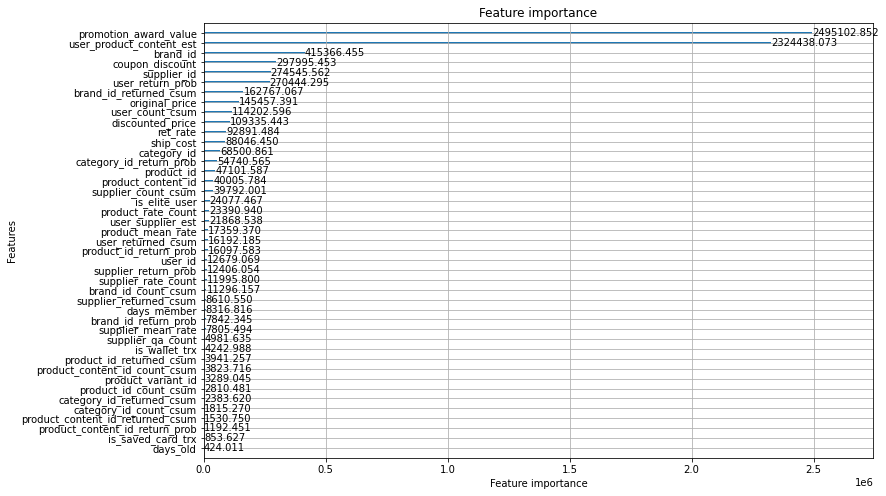

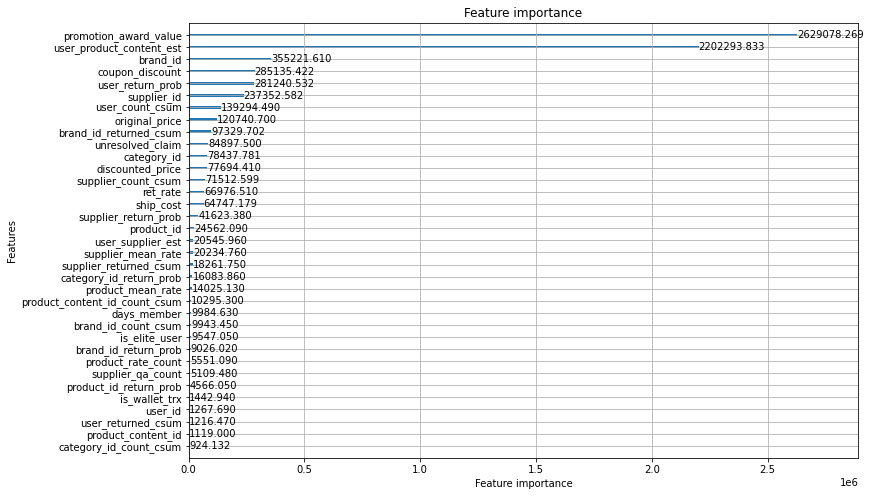

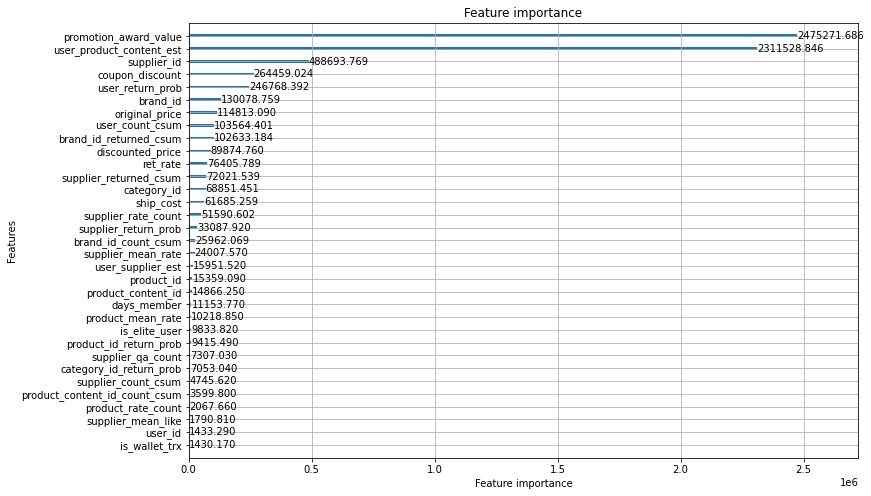

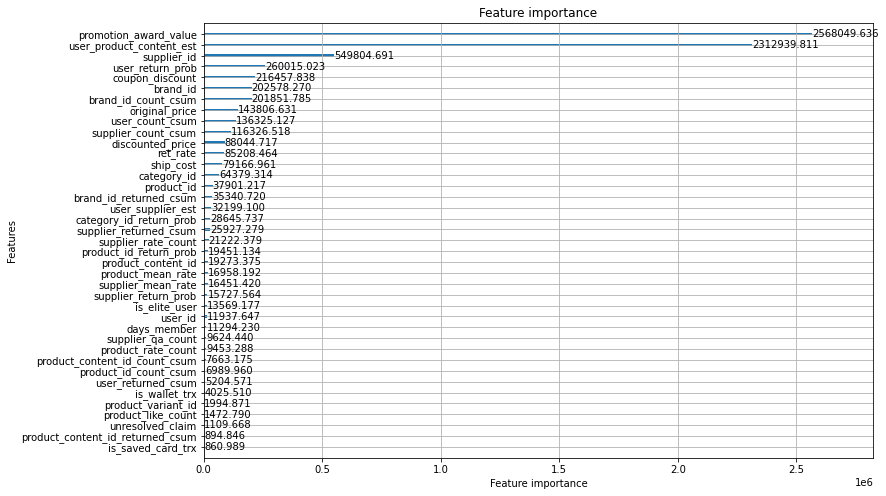

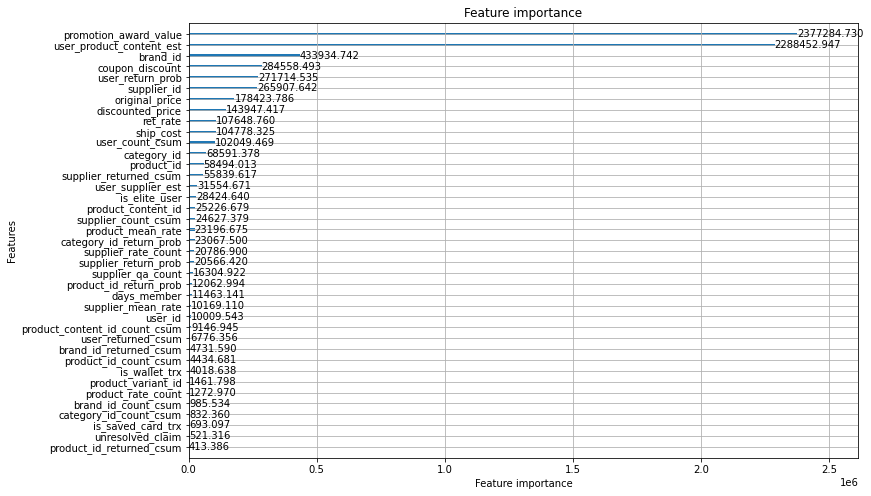

In [45]:
skf = StratifiedKFold(n_splits=5)
i = 0
f1_scores = []
auc_scores = []
thresholds = []
for train_ind, val_ind in skf.split(train_transactions, train_transactions['is_returned']):
    train_data = train_transactions.iloc[train_ind]
    val_data = train_transactions.iloc[val_ind]
    lgb_clf = lgb.LGBMClassifier(num_leaves=31, learning_rate=0.3, 
                             n_estimators=1500, objective='binary', first_metric_only=True)
    lgb_clf.fit(train_data.drop(columns=['is_returned', 'id']), train_data['is_returned']
               ,eval_set=(val_data.drop(columns=['is_returned', 'id']), val_data['is_returned'])
               ,eval_metric=['auc'] 
               ,early_stopping_rounds=100
               ,verbose=50
              ,categorical_feature=cat_cols
                   )
    print(lgb.plot_importance(lgb_clf, height=0.2, figsize=(12,8), importance_type='gain'))
    auc_scores.append(lgb_clf.best_score_['valid_0']['auc'])
    val_preds = lgb_clf.predict_proba(val_data.drop(columns=['is_returned', 'id']))[:,1]
    val_f1_score, val_threshold = get_best_threshold(val_data['is_returned'], val_preds)
    val_threshold %= 100
    print('F1 score is:', val_f1_score, 'Threshold is:', val_threshold)                                
    f1_scores.append(val_f1_score)
    thresholds.append(val_threshold)                
    if i == 0:
        preds = lgb_clf.predict_proba(test_transactions.drop(columns=['is_returned', 'id']))[:,1]
    else:
        preds += lgb_clf.predict_proba(test_transactions.drop(columns=['is_returned', 'id']))[:,1]
    i += 1
the_threshold = mean(thresholds)                                
preds /= 5
test_transactions['is_returned'] = (preds > the_threshold).astype(int)
predictions = test_transactions[['id', 'is_returned']].groupby('id').max().reset_index()
predictions = predictions.rename(columns={'is_returned': 'expected'})
predictions['expected'] = predictions['expected'].astype(int)                               
print('\n')                                    
print('Expected f1 score:', mean(f1_scores))
print('Expected AUC score:', mean(auc_scores))
print('Mean threshold is:', the_threshold)                                    

In [46]:
predictions.to_csv('preds_new_v0.csv', index=False)

In [47]:
#preds = lgb_clf.predict(test_transactions.drop(columns=['is_returned', 'id']))

In [48]:
'''
test_transactions['is_returned'] = preds
predictions = test_transactions[['id', 'is_returned']].groupby('id').max().reset_index()
predictions = predictions.rename(columns={'is_returned': 'expected'})
predictions['expected'] = predictions['expected'].astype(int)
'''

"\ntest_transactions['is_returned'] = preds\npredictions = test_transactions[['id', 'is_returned']].groupby('id').max().reset_index()\npredictions = predictions.rename(columns={'is_returned': 'expected'})\npredictions['expected'] = predictions['expected'].astype(int)\n"

In [49]:
#predictions.to_csv('preds_v2.csv', index=False)

In [50]:
###########################################################################

In [51]:
#test_transactions = transactions[transactions['product_content_id'].isin(test['product_content_id'].unique())][transactions['is_returned'].isna()]

In [52]:
#transactions.set_index('id')[(transactions.groupby('id').mean()['is_returned'] != 0) and (transactions.groupby('id').mean()['is_returned'] != 1)] 

In [53]:
#transactions.info()